In [53]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from load_battery_discharge_data import load_battery_test_data

from cmdstanpy import CmdStanModel
import pandas as pd

import feature_extraction.features as features

In [5]:
root_battery_data = "./analyzed_dataset"

battery_number = "B0005"

metadata_path = "./cleaned_dataset/metadata.csv"

In [6]:
battery_datasets = load_battery_test_data(root_battery_data, battery_number, metadata_path)

In [9]:
sample_dataset = battery_datasets["B0005"]["05122"]
print(sample_dataset)

{'discharge_capacity': 1.8564874208181574, 'data':      Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0            4.191492         -0.004902             24.330034       -0.0006   
1            4.190749         -0.001478             24.325993       -0.0006   
2            3.974871         -2.012528             24.389085       -1.9982   
3            3.951717         -2.013979             24.544752       -1.9982   
4            3.934352         -2.011144             24.731385       -1.9982   
..                ...               ...                   ...           ...   
192          3.258705         -0.001513             35.296711       -0.0006   
193          3.264121         -0.001532             35.021738       -0.0006   
194          3.269030         -0.000406             34.754871       -0.0006   
195          3.273207         -0.000388             34.490078       -0.0006   
196          3.277170         -0.006528             34.230853       -0.0006   



In [25]:
def extract_features_as_lists(battery_datasets, battery_number):
    datasets_for_battery = battery_datasets[battery_number]
    dataset_numbers = datasets_for_battery.keys()

    start_voltages = []
    stop_voltages = []
    current_ptps = []
    capacities = []

    for number in dataset_numbers:
        dataset = datasets_for_battery[number]
        voltage_ts = dataset["data"]["Voltage_measured"]
        current_ts = dataset["data"]["Current_measured"]
        time_ts = dataset["data"]["Time"]
        capacity = dataset["discharge_capacity"]

        start_v = features.get_start_voltage(voltage_ts)
        stop_v = features.get_stop_voltage(voltage_ts)
        current_ptp = features.get_current_ptp(current_ts, time_ts)

        start_voltages.append(start_v)
        stop_voltages.append(stop_v)
        current_ptps.append(current_ptp)
        capacities.append(capacity)

    return pd.DataFrame(data={"start_v": start_voltages, "stop_v": stop_voltages, "current_ptp": current_ptps, "capacity": capacities})

In [28]:
data = extract_features_as_lists(battery_datasets, "B0005")
data.describe()

,start_v,stop_v,current_ptp,capacity
count,168.000000,168.000000,168.000000,168.000000
mean,4.195982,2.648939,2818.496179,1.572502
std,0.004694,0.049297,342.100620,0.190413
min,4.184535,2.455679,2307.172000,1.287453
25%,4.195443,2.636105,2490.999500,1.390021
50%,4.196905,2.660192,2789.336000,1.557085
75%,4.198993,2.682589,3173.187000,1.769163
max,4.222920,2.699983,3331.078000,1.856487


In [29]:
data.head()

,start_v,stop_v,current_ptp,capacity
0,4.198342,2.665511,3074.141,1.715807
1,4.199185,2.697943,3204.047,1.788443
2,4.195756,2.699226,2427.328,1.354322
3,4.184535,2.664632,2372.500,1.323872
4,4.189876,2.649564,3255.109,1.814202


In [30]:
data["start_v"]

0      4.198342
1      4.199185
2      4.195756
3      4.184535
4      4.189876
         ...   
163    4.188916
164    4.196993
165    4.196689
166    4.199247
167    4.187339
Name: start_v, Length: 168, dtype: float64

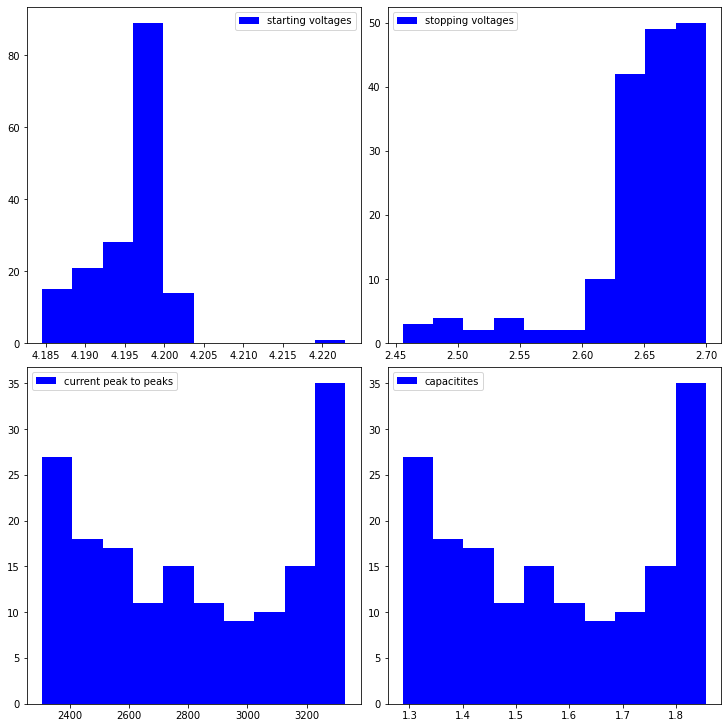

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
ax[0,0].hist(data["start_v"].values, color='b', label=f'starting voltages')
ax[0,1].hist(data["stop_v"].values, color='b', label=f'stopping voltages')
ax[1,0].hist(data["current_ptp"].values, color='b', label=f'current peak to peaks')
ax[1,1].hist(data["capacity"].values, color='b', label=f'capacitites')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

plt.show()

In [33]:
start_v = data["start_v"][:]
stop_v = data["stop_v"][:]
current_ptp = data["current_ptp"][:]
capacity = data["capacity"][:]

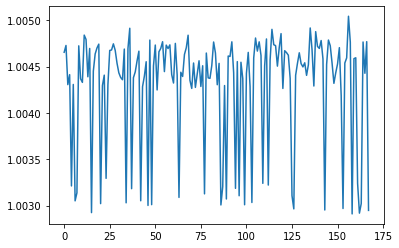

In [103]:
current_div = current_ptp.values / 1800.0
plt.plot(capacity.values/current_div)
plt.show()

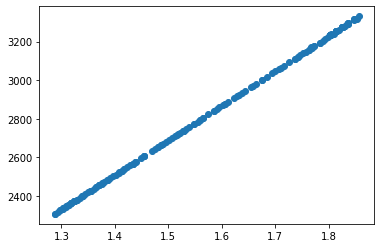

In [104]:
plt.scatter(x=capacity.values, y=current_ptp.values)

# Model with just current ptp

In [36]:
current_ptp.describe()

count     168.000000
mean     2818.496179
std       342.100620
min      2307.172000
25%      2490.999500
50%      2789.336000
75%      3173.187000
max      3331.078000
Name: current_ptp, dtype: float64

In [38]:
current_ptp_scaled = current_ptp.rename("current_ptp_scaled", inplace=False)
current_ptp_scaled /= 1000.0
current_ptp_scaled.describe()

count    168.000000
mean       2.818496
std        0.342101
min        2.307172
25%        2.490999
50%        2.789336
75%        3.173187
max        3.331078
Name: current_ptp_scaled, dtype: float64

In [39]:
current_ptp_scaled_centered = current_ptp_scaled.rename("current_ptp_scaled_centered", inplace=False)
current_ptp_scaled_centered -= current_ptp_scaled_centered.mean()
current_ptp_scaled_centered.describe()

count    1.680000e+02
mean     2.669822e-16
std      3.421006e-01
min     -5.113242e-01
25%     -3.274967e-01
50%     -2.916018e-02
75%      3.546908e-01
max      5.125818e-01
Name: current_ptp_scaled_centered, dtype: float64

Prior predictive checks

In [88]:
#  the values of current ptp are in [-0.5, 0.5] and capacity is more/less 1.4
bounds = (1.2, 1.8)

ptp_max = current_ptp_scaled_centered.max()
ptp_min = current_ptp_scaled_centered.min()

theta = (bounds[1] - bounds[0]) / (ptp_max - ptp_min)
alpha = bounds[0] - theta * ptp_min

print(f"theta: {theta}")
print(f"alpha: {alpha}")

theta = (bounds[1] - bounds[0]) / (ptp_max - ptp_min)
alpha = bounds[1] - theta * ptp_max

print(f"theta: {theta}")
print(f"alpha: {alpha}")

theta: 0.5859912921693986
alpha: 1.4996315161185276
theta: 0.5859912921693986
alpha: 1.4996315161185276


In [200]:
%%writefile ppc/model_simple_ppc.stan

data {
    int<lower=0> N;
    vector[N] ptps;
}

generated quantities {
    real alpha = normal_rng(1.5, 0.3);
    real theta = normal_rng(0.6, 0.2);
    real sigma = normal_rng(0.0001, 0.00001); // measurement error is assumed to be very low
    vector[N] capacity;
    
    for (i in 1:N) {
     capacity[i] = normal_rng(alpha + theta * ptps[i], sigma);
    }
}

Overwriting ppc/model_simple_ppc.stan


In [220]:
data_ppc = {
    "N": 168,
    "ptps": np.linspace(current_ptp_scaled_centered.min(), current_ptp_scaled_centered.max(), 168)
}

In [221]:
model_simple_ppc = CmdStanModel(stan_file="ppc/model_simple_ppc.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [222]:
R = 1000
ppc_sim = model_simple_ppc.sample(data=data_ppc,
                                  iter_sampling=R,
                                  iter_warmup=0,
                                  chains=1,
                                  fixed_param=True,
                                  seed=15072023,
                                  refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [213]:
ppc_df = ppc_sim.draws_pd()
ppc_df.describe()

,lp__,accept_stat__,alpha,theta,sigma,capacity[1],capacity[2],capacity[3],capacity[4],capacity[5],...,capacity[159],capacity[160],capacity[161],capacity[162],capacity[163],capacity[164],capacity[165],capacity[166],capacity[167],capacity[168]
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,1.509872,0.595643,0.000100,1.205304,1.208953,1.212615,1.216267,1.219915,...,1.782320,1.785968,1.789626,1.793274,1.796927,1.800580,1.804233,1.807884,1.811533,1.815180
std,0.0,0.0,0.297238,0.199135,0.000010,0.310213,0.309859,0.309518,0.309172,0.308834,...,0.314439,0.314832,0.315251,0.315662,0.316076,0.316500,0.316923,0.317354,0.317781,0.318220
min,0.0,0.0,0.532025,-0.027205,0.000073,0.268091,0.271200,0.274529,0.277436,0.280666,...,0.768176,0.771472,0.774478,0.777586,0.780713,0.783760,0.787074,0.790038,0.793396,0.796651
25%,0.0,0.0,1.300980,0.464512,0.000093,0.989309,0.993517,0.996738,1.000703,1.004418,...,1.568280,1.570560,1.573115,1.576823,1.580820,1.584682,1.587468,1.590995,1.594742,1.598805
50%,0.0,0.0,1.503320,0.596341,0.000100,1.216435,1.219350,1.224070,1.227680,1.232225,...,1.776780,1.779930,1.783485,1.786525,1.789690,1.792820,1.796210,1.800245,1.804195,1.808015
75%,0.0,0.0,1.711380,0.726948,0.000107,1.399390,1.403182,1.406427,1.410118,1.413992,...,2.004192,2.007817,2.011595,2.015213,2.020142,2.024590,2.028552,2.033042,2.037698,2.040678
max,0.0,0.0,2.456990,1.168890,0.000135,2.184780,2.187080,2.189580,2.191930,2.194490,...,2.881910,2.887770,2.893680,2.899080,2.904960,2.910560,2.916260,2.922090,2.927860,2.933490


In [223]:
ppc_df.head(5)

,lp__,accept_stat__,alpha,theta,sigma,capacity[1],capacity[2],capacity[3],capacity[4],capacity[5],...,capacity[159],capacity[160],capacity[161],capacity[162],capacity[163],capacity[164],capacity[165],capacity[166],capacity[167],capacity[168]
0,0.0,0.0,1.48484,0.816504,0.000101,1.067390,1.072170,1.077430,1.082410,1.08733,...,1.85840,1.86323,1.86847,1.87325,1.87825,1.88322,1.88833,1.89348,1.89829,1.90340
1,0.0,0.0,1.46966,0.437461,0.000108,1.245960,1.248460,1.251210,1.254370,1.25663,...,1.66964,1.67221,1.67506,1.67780,1.68047,1.68311,1.68574,1.68837,1.69119,1.69376
2,0.0,0.0,1.39823,0.784127,0.000112,0.997324,1.002250,1.006930,1.011710,1.01650,...,1.75696,1.76179,1.76643,1.77120,1.77613,1.78094,1.78562,1.79036,1.79541,1.80030
3,0.0,0.0,1.26267,0.354169,0.000091,1.081630,1.083640,1.085820,1.088210,1.09015,...,1.42455,1.42666,1.42898,1.43124,1.43327,1.43533,1.43759,1.43995,1.44185,1.44415
4,0.0,0.0,1.23107,0.549602,0.000096,0.950008,0.953342,0.956633,0.960333,0.96342,...,1.48250,1.48593,1.48917,1.49255,1.49590,1.49941,1.50264,1.50602,1.50958,1.51285


In [227]:
alphas = ppc_df['alpha'].values
thetas = ppc_df['theta'].values
sigma = ppc_df['sigma'].values
ppc_capacity = ppc_df.loc[:, 'capacity[1]':'capacity[168]'].values

In [228]:
ppc_capacity.shape

(1000, 168)

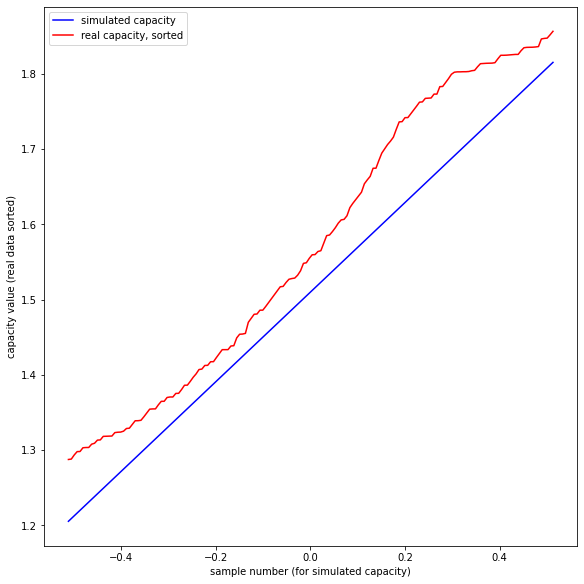

In [242]:
sim_capacity = np.mean(ppc_capacity, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
ax.plot(data_ppc['ptps'], sim_capacity, color='b', label='simulated capacity')
ax.plot(data_ppc['ptps'], np.sort(capacity), color='r', label='real capacity, sorted')
ax.legend()
ax.set_xlabel('sample number (for simulated capacity)')
ax.set_ylabel('capacity value (real data sorted)')
plt.show()

Now let's prepare the model

In [194]:
%%writefile model/model_simple_fit.stan

data {
    int<lower=0> N;
    vector[N] current_ptp;
    vector[N] capacity;
}

parameters {
    real alpha;
    real theta;
    real sigma;
}

model {
    alpha ~ normal(1.6, 0.1);
    theta ~ normal(0.6, 0.05);
    sigma ~ normal(0.0001, 0.00001);

    capacity ~ normal(alpha + theta * current_ptp, sigma);
}

generated quantities {
    vector[N] single_capacity;
    for (i in 1:N) { 
        single_capacity[i] = normal_rng(alpha + theta * current_ptp[i], sigma);
    }
}

Overwriting model/model_simple_fit.stan


In [195]:
model_simple_fit = CmdStanModel(stan_file="model/model_simple_fit.stan")

INFO:cmdstanpy:compiling stan file /home/da_project/battery-pack-model-and-data/model/model_simple_fit.stan to exe file /home/da_project/battery-pack-model-and-data/model/model_simple_fit


INFO:cmdstanpy:compiled model executable: /home/da_project/battery-pack-model-and-data/model/model_simple_fit


In [234]:
samples = model_simple_fit.sample(data={"N":current_ptp_scaled_centered.size,
                                        "current_ptp":current_ptp_scaled_centered.values, 
                                        "capacity":capacity}, 
                                 seed=15072023)
fit_df = samples.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 4 |▍         | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)






chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [235]:
fit_df.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,sigma,...,single_capacity[159],single_capacity[160],single_capacity[161],single_capacity[162],single_capacity[163],single_capacity[164],single_capacity[165],single_capacity[166],single_capacity[167],single_capacity[168]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,388.270134,0.942688,0.001267,3.772750,25.437500,0.0,-386.789183,1.572502,0.556595,0.000369,...,1.838011,1.627089,1.641950,1.836384,1.827608,1.826254,1.453685,1.401377,1.699147,1.816562
std,1.210404,0.081913,0.000576,1.198944,20.135962,0.0,1.714639,0.000028,0.000082,0.000005,...,0.000373,0.000369,0.000371,0.000378,0.000376,0.000378,0.000366,0.000364,0.000370,0.000370
min,381.540000,0.253863,0.000273,1.000000,1.000000,0.0,-389.680000,1.572410,0.556285,0.000351,...,1.836640,1.625850,1.640600,1.835120,1.826420,1.824860,1.452380,1.400230,1.697740,1.815310
25%,387.723750,0.921968,0.001226,3.000000,11.000000,0.0,-388.051250,1.572480,0.556540,0.000365,...,1.837760,1.626850,1.641700,1.836130,1.827350,1.826000,1.453440,1.401130,1.698900,1.816310
50%,388.583000,0.977267,0.001566,4.000000,19.000000,0.0,-387.112500,1.572500,0.556592,0.000369,...,1.838005,1.627090,1.641950,1.836390,1.827610,1.826250,1.453680,1.401370,1.699150,1.816560
75%,389.160000,0.997133,0.001607,5.000000,31.000000,0.0,-385.893000,1.572520,0.556653,0.000372,...,1.838260,1.627340,1.642210,1.836640,1.827870,1.826510,1.453930,1.401630,1.699390,1.816810
max,389.768000,1.000000,0.001662,6.000000,127.000000,0.0,-375.916000,1.572600,0.556889,0.000388,...,1.839280,1.628400,1.643430,1.837600,1.828980,1.827560,1.454990,1.402840,1.700490,1.817740


In [236]:
fit_df.head(15)

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,sigma,...,single_capacity[159],single_capacity[160],single_capacity[161],single_capacity[162],single_capacity[163],single_capacity[164],single_capacity[165],single_capacity[166],single_capacity[167],single_capacity[168]
0,388.729,0.954781,0.001662,4.0,27.0,0.0,-387.040,1.57248,0.556568,0.000362,...,1.83827,1.62720,1.64204,1.83598,1.82763,1.82607,1.45338,1.40148,1.69930,1.81622
1,388.795,0.959348,0.001662,3.0,11.0,0.0,-386.259,1.57254,0.556565,0.000371,...,1.83858,1.62741,1.64199,1.83629,1.82824,1.82582,1.45386,1.40121,1.69882,1.81646
2,388.922,0.999726,0.001662,3.0,7.0,0.0,-388.590,1.57254,0.556557,0.000370,...,1.83836,1.62759,1.64170,1.83657,1.82741,1.82664,1.45360,1.40136,1.69866,1.81643
3,388.086,0.990913,0.001662,3.0,7.0,0.0,-387.856,1.57255,0.556559,0.000368,...,1.83772,1.62725,1.64228,1.83637,1.82737,1.82539,1.45392,1.40094,1.69884,1.81627
4,388.642,0.997010,0.001662,3.0,7.0,0.0,-387.801,1.57254,0.556564,0.000367,...,1.83806,1.62747,1.64167,1.83644,1.82752,1.82573,1.45359,1.40135,1.69962,1.81707
5,388.393,0.941694,0.001662,4.0,15.0,0.0,-387.835,1.57247,0.556544,0.000363,...,1.83819,1.62697,1.64181,1.83644,1.82762,1.82608,1.45376,1.40106,1.69860,1.81622
6,389.121,0.778987,0.001662,3.0,15.0,0.0,-385.329,1.57250,0.556541,0.000374,...,1.83822,1.62663,1.64236,1.83611,1.82746,1.82626,1.45381,1.40148,1.69850,1.81635
7,389.279,0.979622,0.001662,3.0,11.0,0.0,-388.778,1.57250,0.556548,0.000364,...,1.83745,1.62727,1.64216,1.83628,1.82804,1.82631,1.45375,1.40163,1.69930,1.81679
8,388.938,0.924880,0.001662,5.0,63.0,0.0,-387.758,1.57252,0.556677,0.000371,...,1.83784,1.62692,1.64245,1.83640,1.82756,1.82580,1.45306,1.40165,1.69921,1.81645
9,389.172,0.966484,0.001662,3.0,11.0,0.0,-388.532,1.57251,0.556658,0.000372,...,1.83780,1.62728,1.64186,1.83596,1.82814,1.82653,1.45340,1.40155,1.69927,1.81708


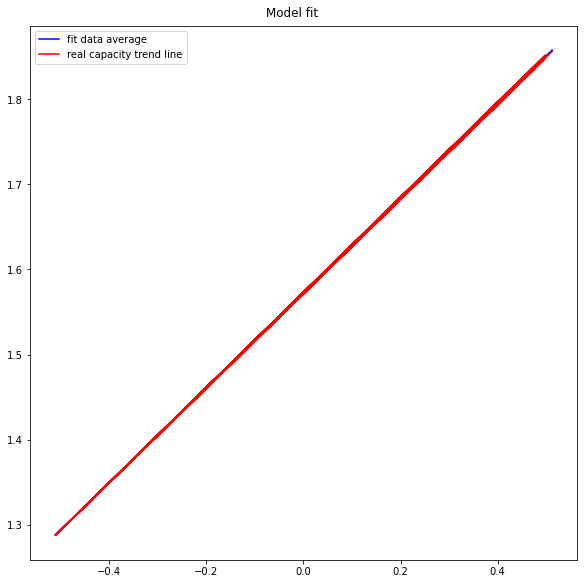

In [244]:
fit_capacity = fit_df.loc[:, "single_capacity[1]":"single_capacity[168]"].values
fig, ax = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
ax.plot(current_ptp_scaled_centered.values, np.mean(fit_capacity, axis=0), color='b', label='fit data average')
ax.plot(current_ptp_scaled_centered.values, capacity, color='r', label='real capacity trend line')
ax.legend()
fig.suptitle("Model fit")
plt.show()